In [1]:
import pandas as pd
import tiktoken

from openai.embeddings_utils import get_embedding

In [2]:
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191

In [3]:
input_datapath = r"Sheet1.csv"  # to save space, we provide a pre-filtered dataset
df = pd.read_csv(input_datapath)
df = df[["text", "intent"]]
df = df.dropna()

In [4]:
encoding = tiktoken.get_encoding(embedding_encoding)

# omit reviews that are too long to embed
df["n_tokens"] = df.text.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens]
len(df)

8626

In [5]:
df["embedding"] = df.text.apply(lambda x: get_embedding(x, engine=embedding_model))
df.to_csv("embedded.csv")

In [6]:
import numpy as np
import pandas as pd

# load data
datafile_path = r"embedded.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)  
matrix = np.vstack(df.embedding.values)
matrix.shape

(8626, 1536)

In [8]:
from sklearn.cluster import KMeans

n_clusters = len(np.unique(df["intent"]))

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
centers = kmeans.cluster_centers_
df["Cluster"] = labels
# df["Centers"] = centers
# df.groupby("Cluster").Score.mean().sort_values()
df

c:\Users\ozgur\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Unnamed: 0,text,intent,n_tokens,embedding,Cluster
0,0,önce müşteri olma işlemini gerçekleştir,musteri_olma,16,"[-0.007942580617964268, -0.025781257078051567,...",219
1,1,musteri olma islemimi gerceklestir,musteri_olma,13,"[-0.0302327498793602, -0.014673748053610325, -...",35
2,2,banka müşterisi olma islemi gerceklestir,musteri_olma,16,"[-0.02522432617843151, -0.01610517129302025, 0...",219
3,3,banka müşterisi olma islemini yap,musteri_olma,12,"[-0.035806819796562195, -0.023004993796348572,...",219
4,4,müşteri olma,musteri_olma,7,"[-0.01564975082874298, -0.028498081490397453, ...",219
...,...,...,...,...,...,...
8621,8621,Katılım bankalarına vergi tahsil hakkı ne zama...,KB_VergiTahsis_zamani,19,"[-0.00893468875437975, -0.042192649096250534, ...",84
8622,8622,Katılım bankalarına vergi toplama yetkisi ne z...,KB_VergiTahsis_zamani,20,"[-0.009693920612335205, -0.04339367896318436, ...",84
8623,8623,Katılım bankaları ne zaman vergi tahsil edebil...,KB_VergiTahsis_zamani,21,"[-0.009146771393716335, -0.03977527841925621, ...",84
8624,8624,Hangi tarihte katılım bankalarına vergi tahsil...,KB_VergiTahsis_zamani,22,"[-0.01284458115696907, -0.03932976350188255, 0...",84


In [14]:
len(centers[0])

1536

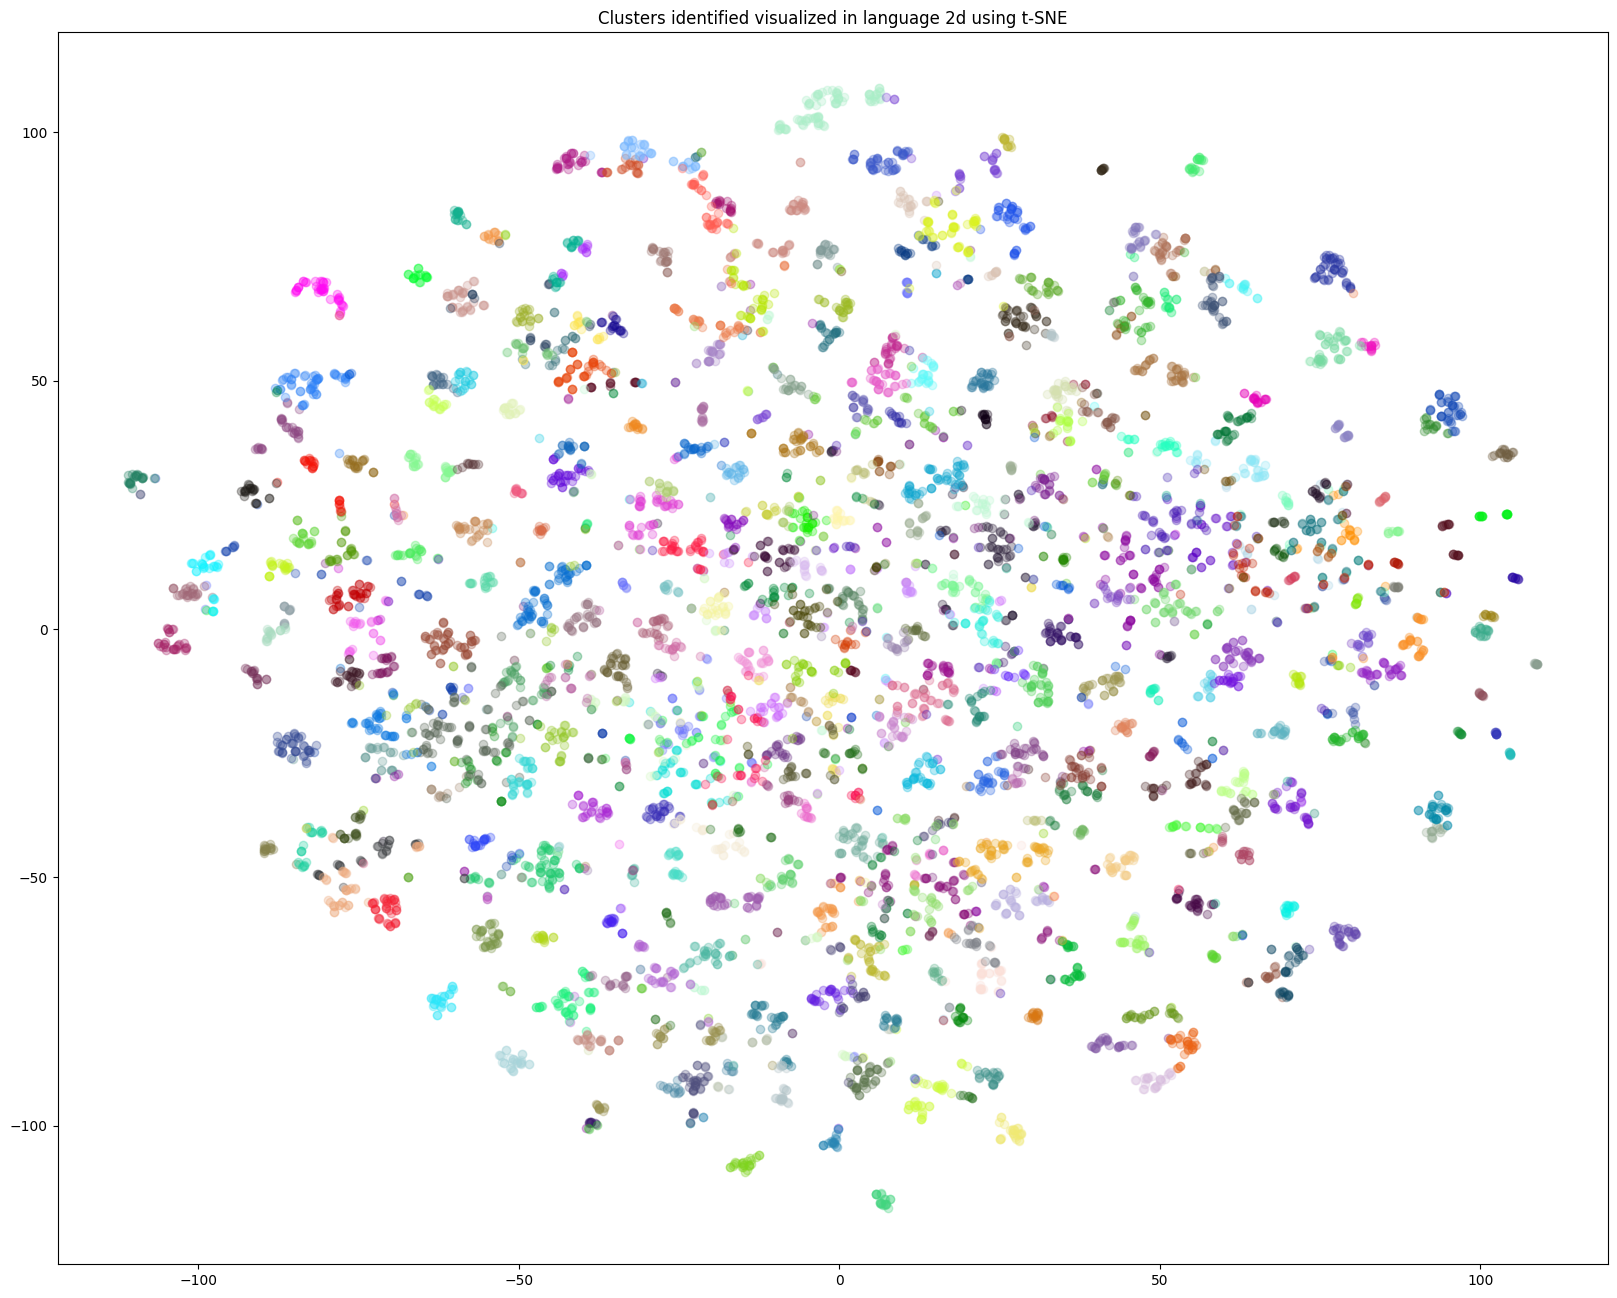

In [17]:
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="pca", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

plt.figure(figsize=(20,16))
x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

colors = []
for i in range(len(set(df.Cluster))):
    colors.append('#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))

for i, color in enumerate(colors):
    xs = np.array(x)[df.Cluster == i]
    ys = np.array(y)[df.Cluster == i]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()
plt.scatter(avg_x, avg_y, color=color, s=10)
plt.title("Clusters identified visualized in language 2d using t-SNE")
plt.show()
